In [1557]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
plt.style.use('ggplot')

In [1558]:
state_actions = pd.read_csv("actions.csv")
cases_deaths = pd.read_csv("cases-deaths.csv")

len(state_actions), len(cases_deaths)

(52, 54)

In [1559]:
state_actions.head()

,Location,Stay At Home Order,Mandatory Quarantine for Travelers,Non-Essential Business Closures,Large Gatherings Ban,State-Mandated School Closures,Bar/Restaurant Limits,Primary Election Postponement,Emergency Declaration,Footnotes
0,United States,Statewide (28); Affected Counties (2); High-ri...,All Travelers (9); All Air Travelers (1); From...,All Non-Essential Businesses (29); All Non-Ess...,All Gatherings Prohibited (16); >10 Prohibited...,Yes (46); Effectively Closed (2); Other (1); N...,Closed except for takeout/delivery (44); Limit...,Yes (12); No (39),Yes (51); No (0),NaN
1,Alabama,-,-,Other,>10 People Prohibited,Yes,Closed except for takeout/delivery,Yes,Yes,1.0
2,Alaska,Statewide,All Travelers,All Non-Essential Businesses,All Gatherings Prohibited,Yes,Closed except for takeout/delivery,-,Yes,NaN
3,Arizona,Statewide,-,All Non-Essential Businesses,>10 People Prohibited,Yes,Closed except for takeout/delivery,-,Yes,NaN
4,Arkansas,-,-,-,>10 People Prohibited,Yes,Closed except for takeout/delivery,-,Yes,NaN


In [1560]:
cases_deaths.head()

,Location,Number of COVID-19 Cases,"COVID-19 Cases per 1,000,000 Population",Deaths from COVID-19,"COVID-19 Deaths per 1,000,000 Population"
0,Alabama,949,193.547663,15,3.059236
1,Alaska,119,162.669419,3,4.100910
2,Arizona,"1,289",177.091650,24,3.297284
3,Arkansas,508,168.334325,8,2.650934
4,California,"7,540",190.827026,153,3.872219


### Cleanup

In [1561]:
cases_deaths.set_index("Location", inplace=True)
cases_deaths["Deaths from COVID-19"] = cases_deaths["Deaths from COVID-19"].astype(float)
cases_deaths["Number of COVID-19 Cases"] = cases_deaths["Number of COVID-19 Cases"].apply(lambda s: s.replace(",", "")).astype(float)
state_actions.drop(index=[0], inplace=True)
state_actions.set_index("Location", inplace=True)
state_actions.drop(columns=["Primary Election Postponement", "Footnotes"], inplace=True)

In [1562]:
actions_cases = state_actions.merge(cases_deaths, on="Location", how="outer")
actions_cases.dropna(inplace=True)
actions_cases.drop(index="District of Columbia", inplace=True)

len(actions_cases)

50

In [1563]:
actions_cases.head()

,Stay At Home Order,Mandatory Quarantine for Travelers,Non-Essential Business Closures,Large Gatherings Ban,State-Mandated School Closures,Bar/Restaurant Limits,Emergency Declaration,Number of COVID-19 Cases,"COVID-19 Cases per 1,000,000 Population",Deaths from COVID-19,"COVID-19 Deaths per 1,000,000 Population"
Location,,,,,,,,,,,
Alabama,-,-,Other,>10 People Prohibited,Yes,Closed except for takeout/delivery,Yes,949.0,193.547663,15.0,3.059236
Alaska,Statewide,All Travelers,All Non-Essential Businesses,All Gatherings Prohibited,Yes,Closed except for takeout/delivery,Yes,119.0,162.669419,3.0,4.100910
Arizona,Statewide,-,All Non-Essential Businesses,>10 People Prohibited,Yes,Closed except for takeout/delivery,Yes,1289.0,177.091650,24.0,3.297284
Arkansas,-,-,-,>10 People Prohibited,Yes,Closed except for takeout/delivery,Yes,508.0,168.334325,8.0,2.650934
California,Statewide,-,All Non-Essential Businesses,All Gatherings Prohibited,Effectively Closed,Closed except for takeout/delivery,Yes,7540.0,190.827026,153.0,3.872219


### Initial Analysis

In [1580]:
# find all states that have implemented all state actions in some way or form
strictest = actions_cases[actions_cases.columns[:7]].replace(to_replace="-", value=np.nan).dropna()
avg_cases_strict = np.average(actions_cases[actions_cases.index.isin(strictest.index)]["Number of COVID-19 Cases"])

In [1585]:
avg_cases = np.average(actions_cases[~(actions_cases.index.isin(strictest.index))]["Number of COVID-19 Cases"])

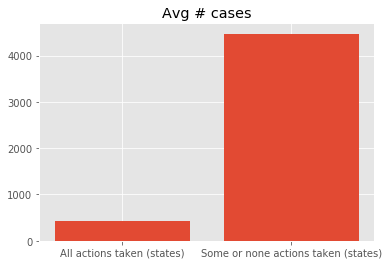

In [1589]:
data = pd.DataFrame([["All actions taken (states)", avg_cases_strict], ["Some or none actions taken (states)", avg_cases]], columns=["actions_ind", "avg_num_deaths"])
plt.bar(data["actions_ind"], data["avg_num_deaths"])
plt.title("Avg # cases")
plt.show()

States that have taken all actions in some way see a much lower avg number of cases nearly 10x lower than that of states who took some or no action(s). Does this mean that taking actions can mitigate case counts? Maybe, I cannot prove causation and more research is required to determine if one action is more effective than the other in the mitigation process.

### Decision Tree Classifier

In [1546]:
threshold = actions_cases.describe()["Deaths from COVID-19"]["50%"]
threshold

15.0

In [1547]:
actions_cases = pd.get_dummies(actions_cases)

In [1548]:
actions_cases["Deaths from COVID-19"] = actions_cases["Deaths from COVID-19"]\
.apply(lambda deaths: 1 if deaths >= threshold else 0)

cols = ["Number of COVID-19 Cases", "COVID-19 Cases per 1,000,000 Population", "COVID-19 Deaths per 1,000,000 Population"]

#actions_cases.drop(columns=cols[0], inplace=True)

actions_cases.head()

,Number of COVID-19 Cases,"COVID-19 Cases per 1,000,000 Population",Deaths from COVID-19,"COVID-19 Deaths per 1,000,000 Population",Stay At Home Order_-,Stay At Home Order_Affected Counties,Stay At Home Order_High-risk Groups,Stay At Home Order_Statewide,Mandatory Quarantine for Travelers_-,Mandatory Quarantine for Travelers_All Air Travelers,...,Large Gatherings Ban_Other,State-Mandated School Closures_-,State-Mandated School Closures_Effectively Closed,State-Mandated School Closures_Other,State-Mandated School Closures_Yes,Bar/Restaurant Limits_-,Bar/Restaurant Limits_Closed except for takeout/delivery,Bar/Restaurant Limits_Limited On-site Service,Bar/Restaurant Limits_Other,Emergency Declaration_Yes
Location,,,,,,,,,,,,,,,,,,,,,
Alabama,949.0,193.547663,1,3.059236,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1
Alaska,119.0,162.669419,0,4.100910,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,1
Arizona,1289.0,177.091650,1,3.297284,0,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,1
Arkansas,508.0,168.334325,0,2.650934,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1
California,7540.0,190.827026,1,3.872219,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,1


In [1549]:
train, test = train_test_split(actions_cases, test_size=0.2)

In [1550]:
y = train["Deaths from COVID-19"].values
X = train.drop(columns=["Deaths from COVID-19"]).values
y_test = test["Deaths from COVID-19"].values
X_test = test.drop(columns=["Deaths from COVID-19"]).values

In [1551]:
dt = DecisionTreeClassifier()
dt.fit(X, y)
dt.score(X_test, y_test)

0.9

### Training results questions

How accurate is your model? (I was able to get between 0.7 and 0.9 accuracies depending on the data split)

    I ran the training multiple times and the model got a score between .7 and .9 as well.

How good is that above the most common baseline?

    The baseline for this data is .52 so the model performed around .18 and .38 points better than the baseline.
    
What do you think your model learned?

    It learned to take the features (state actions/cases/deaths) and follow a path of decisions to determine if a state given features had 15 or more total deaths.

### What the decision tree learned

[Text(133.92000000000002, 190.26, 'X[0] <= 560.0\ngini = 0.499\nsamples = 40\nvalue = [19, 21]'),
 Text(66.96000000000001, 135.9, 'gini = 0.0\nsamples = 16\nvalue = [16, 0]'),
 Text(200.88000000000002, 135.9, 'X[2] <= 2.629\ngini = 0.219\nsamples = 24\nvalue = [3, 21]'),
 Text(133.92000000000002, 81.53999999999999, 'X[0] <= 2522.0\ngini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(66.96000000000001, 27.180000000000007, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(200.88000000000002, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(267.84000000000003, 81.53999999999999, 'gini = 0.0\nsamples = 20\nvalue = [0, 20]')]

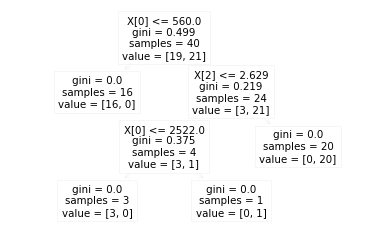

In [1552]:
tree.plot_tree(dt)

What does it mean that the number of cases is the most informative feature for predicting if there were t or more deaths?

    Number of cases yields the highest "purity" in the child nodes which means that the child nodes are less evenly split which leads to cleaner decision making of the model.

Why do you think using the 50th percentile for t was appropriate?

    This is a binary classifier and it seems intuitive to use the median number of cases to label each state above/equal to or under the 50% percentile.

How many states is 10% of the data? Is that enough to get a good indication of whether or not your model is working? What if you tried a cross-validation?

    5. I don't think so. Cross validating would help with overfitting the training data, but even then, such a small sample size will result in an increase in cross validation variance.

How well does your model perform if you remove the number of cases as a feature? What does this say about our hypothesis that the state actions can predict if a state will have had t deaths or more?

    It performs much worse with a score ranging between .4 and .8. This says that the state actions might be less important features to this classification than the cases and death counts and that the hypothesis might be wrong.

What do you interpret your model is learning when the number of cases are present as a feature? What do you interpret your model is learning when the number of cases is not included as a feature? What does that say about the data?

    When the number of cases are present as a feature, it learns that the number of cases is the most suited features to start the decision tree. The tree plot also shows that the model learned the best way to recursively build itself was to use mostly features related to cases/deaths counts.
    
    When the number of cases is not included as a feature, it learns that the COVID-19 Cases per 1,000,000 Population feature is the most suited feature to start the decision tree. I noticed also that without the number of cases as a feature, the model started using the other state action one-hot vector columns in it's decision branches.
    
    It's starting to seem like the features related to case/death counts are most valuable to this model and achieve the highest accuracy scores. I removed all case/death columns from the training data and reran the training multiple times. The model accuracy score ranged between .4 and .7 which gave the worst results so far.
    
Based on what you understand about Logistic Regression, could you make a similar interpretation if you had used Logistic Regression instead of Decision Trees as your classifier? (Note: if you had used a MLP Neural Network, interpretation is nearly impossible)

    Yes, although with a lot of work. Firstly, since decision trees automatically take care of feature interactions, one would have to implement feature interaction into the logistic regression model manually. Second, logistic regression works best through a single boundary unlike the decision trees which is made up of many boundaries. Outliers would also have to be handled for logistic regression. A decision tree is more robust to outliers up to a point. For this type of classification, I would recommend the decision tree as it is easier to interpret its results.

What else could this data tell you?

    I could cluster the states based on their features and see if distinct groups appear. Then, I could measure the average performance of each group by the case/death counts to see if one group could learn from the other. Since this is snapshot data, I could compare it to the latest version to find out which state's curves are flattening. Using this data, I could create a prescriptive model that might recommend an optimal combination of actions for a state. A hypothesis might be that some states case/death count might be more efficiently mitigated with only a specific subset of actions taken versus all. 
    
    I could use logistic regression to forecast case/death counts which could allow for state's to better prepare their system's and response times. I would have liked to see a timeline of when each state took each action. I would then create a graph that links the states based on the time it took to take actions. This graph would change over time but could be useful for determining if there is any order in which states respond to virus outbreaks. If there is an order, then for states with slower, predicted response times could be focused on to improve response times.